# Predict substructure fingerprints from spectra

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

import numpy as np
import pandas as pd
import keras

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

from functions import *

Using TensorFlow backend.


### **TODO**

- predictive performance per fingerprint bins
- siwtch one fragment on, and see the output
- cdk can give all the fragments of a molecule
- try neutral losses as input?
- a peak has to be in the top-6 peaks in a sliding window
- convolutional layer
- implement tsne cost

### Load GNPS+Massbank data

In [3]:
input_dir = '../data/spectra_gnps_massbank'
input_smiles = '../data/smiles_list.smi'
output_file = '../data/gnps_massbank_data.p'

In [4]:
# prepare_data(input_dir, input_smiles, output_file)
with open(output_file, 'rb') as f: # load data created by prepare_data() above
    data = pickle.load(f)

In [5]:
spectra = data['spectra']
fingerprint_arr = get_cdk_fingerprint_arr('../data/smiles_sub.csv', data['smiles'])

Apply count filtering

In [6]:
df = load_cdk_substructures('../data/substructures.txt', '../data/cdk_substructures.csv', fingerprint_arr)
keep_df, fp_mat, spectra_mat = count_filter(df, fingerprint_arr, spectra, lower=10, upper=3000)
print(spectra_mat.shape, fp_mat.shape)

(7886, 881) (7886, 127)


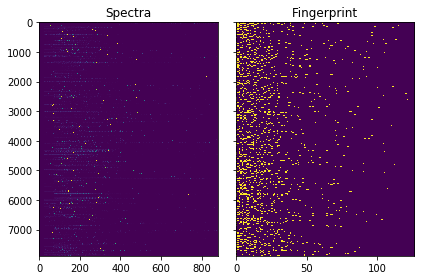

In [7]:
plot_spectra_and_fingerprint_mat(spectra_mat, fp_mat)
# for i in range(5):
#     plot_spectra_and_fingerprint(i)

### Split into training and test sets

In [8]:
pos = int(len(spectra_mat) * 0.8)
x_train = spectra_mat[0:pos, :]
x_test = spectra_mat[pos:, :]
y_train = fp_mat[0:pos, :]
y_test = fp_mat[pos:, :]

In [9]:
input_dim = spectra_mat.shape[1]
output_dim = fp_mat.shape[1]

### Train Baseline Model

The baseline model is scikit-learn logistic regression, fitted using the OneVsRest strategy.

> This strategy, also known as one-vs-all, is implemented in OneVsRestClassifier. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and only one classifier, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy and is a fair default choice.

In [10]:
method = 'Logistic Regression'

In [11]:
classifier = OneVsRestClassifier(LogisticRegression()).fit(x_train, y_train)

In [12]:
y_train_pred = classifier.predict(x_train)
y_test_pred = classifier.predict(x_test)

In [13]:
baseline_df = eval_prec_rec(y_train, y_test, y_train_pred, y_test_pred, method)
display(baseline_df)

,method,data,precision,recall,f1
0,Logistic Regression,train,0.817331,0.260459,0.395033
1,Logistic Regression,test,0.654266,0.192707,0.297723


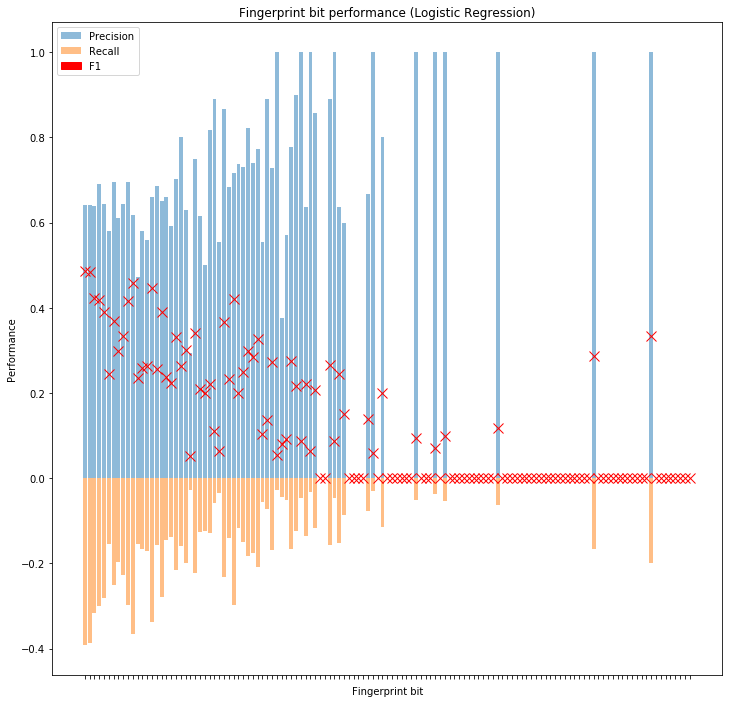

In [14]:
df = eval_fp_bit_performance(y_test, y_test_pred, keep_df)
vis_fp_bit_performance(df, method)

### Train a Basic Encoder-Decoder Model

In [15]:
method = 'Dense Encoder-Decoder'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 881)               0         
_________________________________________________________________
encoder (Dense)              (None, 100)               88200     
_________________________________________________________________
decoder (Dense)              (None, 127)               12827     
Total params: 101,027
Trainable params: 101,027
Non-trainable params: 0
_________________________________________________________________


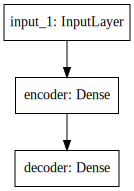

In [16]:
params = {
    'latent_dim': 100
}
model, encoder, decoder = basic_model(input_dim, output_dim, params)
model.summary()
plot_model_in_notebook(model)

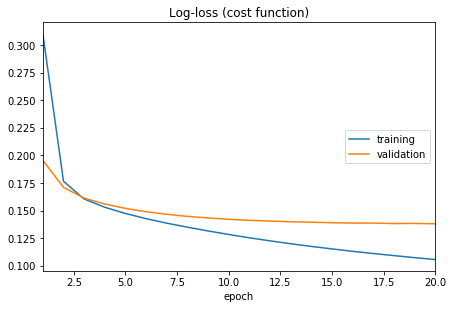

In [17]:
y_train_pred, y_test_pred = train_model(model, encoder, decoder, x_train, x_test, y_train, y_test, epochs=20)

In [18]:
simple_df = eval_prec_rec(y_train, y_test, y_train_pred, y_test_pred, method)
display(simple_df)

,method,data,precision,recall,f1
0,Dense Encoder-Decoder,train,0.82388,0.382560,0.522502
1,Dense Encoder-Decoder,test,0.63429,0.265256,0.374076


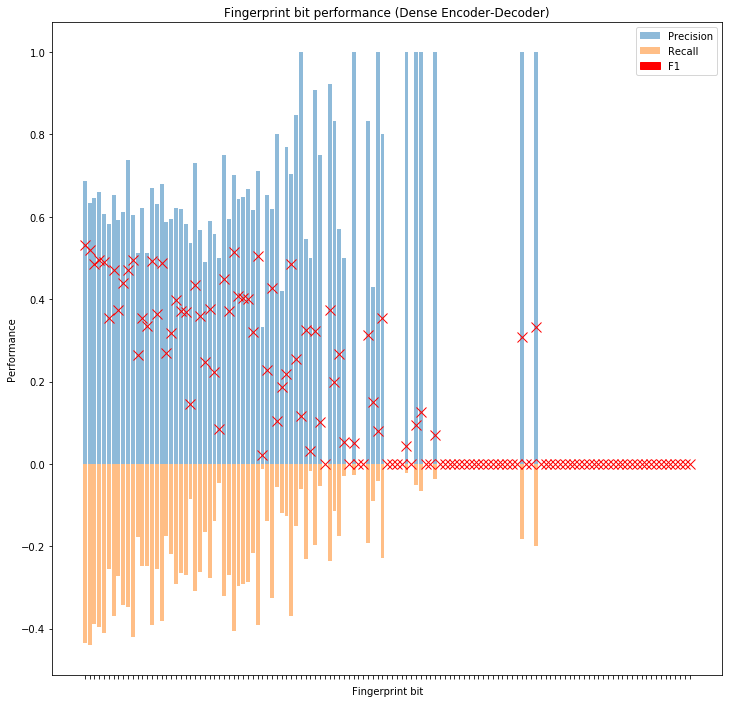

In [19]:
df = eval_fp_bit_performance(y_test, y_test_pred, keep_df, outfile='../data/pred_dense.csv')
vis_fp_bit_performance(df, method)

### CNN Test

In [20]:
method = 'Conv Encoder-Decoder'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 881, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 881, 32)           224       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 881, 16)           3088      
_________________________________________________________________
flatten_1 (Flatten)          (None, 14096)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                902208    
_________________________________________________________________
decoder (Dense)              (None, 127)               8255      
Total params: 913,775
Trainable params: 913,775
Non-trainable params: 0
_________________________________________________________________


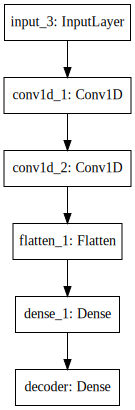

In [21]:
params = {
    'latent_dim': 64,
    # 'l2_lambda': 0.00075
}
model, encoder, decoder = conv_model(input_dim, output_dim, params)
model.summary()
plot_model_in_notebook(model)

In [22]:
x_train_ = np.reshape(x_train, (len(x_train), input_dim, 1))
x_test_ = np.reshape(x_test, (len(x_test), input_dim, 1))

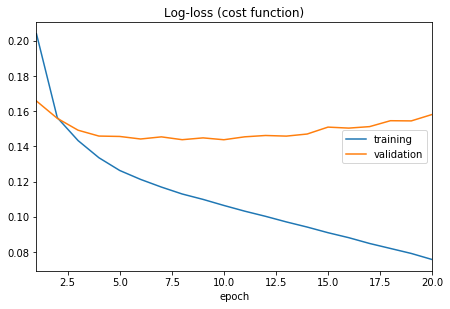

In [23]:
y_train_pred, y_test_pred = train_model(model, encoder, decoder, x_train_, x_test_, y_train, y_test, epochs=20)

In [24]:
cnn_df = eval_prec_rec(y_train, y_test, y_train_pred, y_test_pred, method)
display(cnn_df)

,method,data,precision,recall,f1
0,Conv Encoder-Decoder,train,0.872945,0.620729,0.725543
1,Conv Encoder-Decoder,test,0.594393,0.376535,0.461022


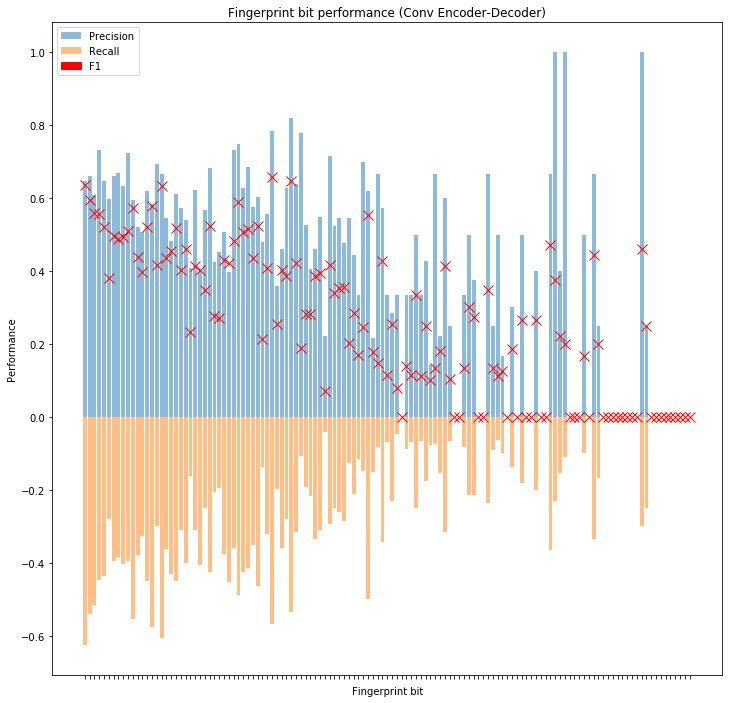

In [25]:
df = eval_fp_bit_performance(y_test, y_test_pred, keep_df, outfile='../data/pred_cnn.csv')
vis_fp_bit_performance(df, method)

### Compare Overall Performance

In [33]:
pd.options.display.float_format = '{:,.2f}'.format

In [34]:
pd.concat([baseline_df, simple_df, cnn_df], axis=0).reset_index(drop=True)

,method,data,precision,recall,f1
0,Logistic Regression,train,0.82,0.26,0.40
1,Logistic Regression,test,0.65,0.19,0.30
2,Dense Encoder-Decoder,train,0.82,0.38,0.52
3,Dense Encoder-Decoder,test,0.63,0.27,0.37
4,Conv Encoder-Decoder,train,0.87,0.62,0.73
5,Conv Encoder-Decoder,test,0.59,0.38,0.46
